## _Track Evaluation_

- Running _`trkx_from_gnn.py`_ produces recostucted tracks (track candiates)
- Running _`trkx_reco_eval.py`_ gives reconstruction evaluation: _`eff, fake rate, dup. rate, etc`_

Let's perform inspection after track evaluation.

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
sys.path.append('..')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## _A. Inspection of Epsilon in DBSCAN_

1. Various $\epsilon$ for DBSCAN in `trkx_from_gnn.py`
2. Choose the best $\epsilon$ based on _`eff, fake rate, dup. rate`_) after `trkx_reco_eval.py`

**NOTE:** The $\epsilon$ in DBSCAN is alternative to chosing a cut on the `edge_score`.

In [7]:
# lists from eval_summary.txt
e_list = [0.10, 0.15, 0.20, 0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95]
eff_list = [90.86,91.68,91.68,91.58,89.84,87.58,85.83,83.57,81.52,76.28]

In [8]:
# covert to ndarrays
eff = np.array(eff_list)
epsilon = np.array(e_list)

In [9]:
len(e_list)==len(eff_list)

True

In [10]:
for i in range(len(e_list)):
    print("epsilon: ", e_list[i])

epsilon:  0.1
epsilon:  0.15
epsilon:  0.2
epsilon:  0.25
epsilon:  0.35
epsilon:  0.45
epsilon:  0.55
epsilon:  0.75
epsilon:  0.85
epsilon:  0.95


In [11]:
#plt.style.use('ggplot')
#mpl.rcParams.update(mpl.rcParamsDefault)

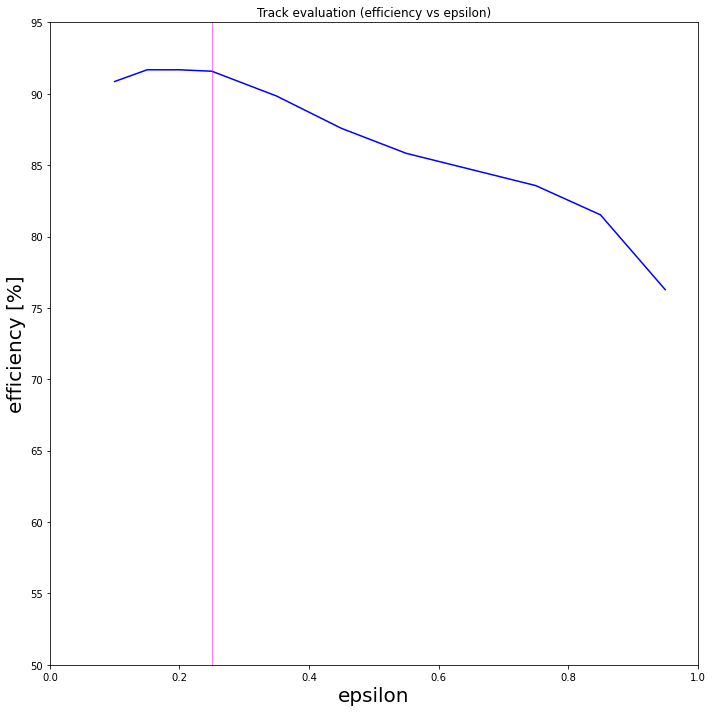

In [66]:
# init subplots
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
ax.plot(epsilon, eff, linestyle='-', linewidth=1.5, color='blue')

plt.axvline(x=0.25, linewidth=0.5, color='magenta')

# plotting params
ax.set_title('Track evaluation (efficiency vs epsilon)')
ax.set_xlabel('epsilon', fontsize=20)
ax.set_ylabel('efficiency [%]', fontsize=20)
ax.set_xlim(0, 1)
ax.set_ylim(50, 95)
ax.grid(False)
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()
fig.savefig("epsilon_eff.png")

## _B. Visualize Test Data_

Inspect easy to difficult to reconstruct tracks. Choose 10 such events and use `score_cut=0.25`

In [13]:
inputdir="run/feature_store/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [14]:
feature_data = torch.load(proc_files[1], map_location=device)

## _C. Inspection on Track Duplication_

- lets plot two reconstructed events, one is `good` and the other a little `bad`
- see an event with duplicated tracks, find out why they are duplicated.

In [15]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [16]:
# event_idx is index of fetched event list. The event_idx=1, means that 
# event_id at event_id=1. Its needed if all events are fetched as a list.
event_idx = 1

### _(+)-Read True Tracks_

In [17]:
# get list of true tracks (test dataset)
inputdir="run/gnn_evaluation/test"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [18]:
# event Data
feature_data = torch.load(proc_files[event_idx], map_location=device)
print("Length of Data: {}".format(len(feature_data)))

Length of Data: 11


In [19]:
feature_data

Data(x=[152, 3], pid=[152], layers=[152], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all/event0000009001', hid=[152], pt=[152], modulewise_true_edges=[2, 141], layerwise_true_edges=[2, 147], edge_index=[2, 691], y_pid=[691], scores=[1382])

### _(+)-Read Reco Track_

In [20]:
inputdir="run/trkx_from_gnn"
trkx_from_gnn = sorted(glob.glob(os.path.join(inputdir, "*")))

In [21]:
reco_tracks = torch.load(trkx_from_gnn[event_idx], map_location=device)
print("Length of Data: {}".format(len(reco_tracks)))

Length of Data: 152


In [22]:
reco_tracks.head()

,hit_id,track_id
0,100,0
1,25,-1
2,51,-1
3,76,1
4,173,2


### _(+)-Read Track Evaluation Data_

In [23]:
inputdir="run/trkx_reco_eval"

In [24]:
evtid = int(trkx_from_gnn[event_idx][-4:])

In [25]:
print("evtid: {}".format(evtid))

evtid: 9001


In [26]:
!./eval.sh $evtid

Out of 1000 events processing 1 events with 1 workers
Output directory: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 9001


In [27]:
# path to HDF5 Store
hdf5_path = inputdir+"/{}_particles.h5".format(evtid)
print(hdf5_path)

run/trkx_reco_eval/9001_particles.h5


In [28]:
df = pd.read_hdf(hdf5_path)
print("Length of Data: {}".format(len(df)))

Length of Data: 10


In [29]:
df.head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,6,0.625777,18,True,True,9001
1,9,0.654691,18,False,True,9001
2,8,1.461128,17,False,True,9001
3,7,1.197729,16,True,True,9001
4,3,0.694913,16,True,True,9001


In [30]:
# Read the Summary of Evaluation
sum_path = inputdir+"/{}_summary.txt".format(evtid)
print(sum_path)

run/trkx_reco_eval/9001_summary.txt


In [31]:
with open(sum_path) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220529-224133
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                    8
Reco. tracks:                   13
Reco. tracks matched:                   13
Reco. tracks matched to POI:                   13
Reco. tracks duplicated:                    5
Tracking Eff.:              80.0000%
Fake rate:                   0.0000%
Duplication Rate:              38.4615%
--------------------------------------------------
Run Time:      20220529-224202
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                    8
Reco. tracks:                   13
Reco. tracks matched:                   13
Reco. tracks matched to POI:                   13
Reco. tracks duplicated:                    5
Tracking Eff.:      

## _(1.) - Plot True Event (Good)_

In [32]:
# The Good Event
event_id = 96

In [33]:
# true events
true_trkx = torch.load(proc_files[event_id], map_location=device)

In [34]:
true_trkx

Data(x=[165, 3], pid=[165], layers=[165], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all/event0000009096', hid=[165], pt=[165], modulewise_true_edges=[2, 155], layerwise_true_edges=[2, 156], edge_index=[2, 804], y_pid=[804], scores=[1608])

In [35]:
np.unique(true_trkx.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [36]:
# hit features
r, phi, ir = true_trkx.x.T

In [37]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [38]:
# compensate scaling
ir = ir.detach().numpy()*100

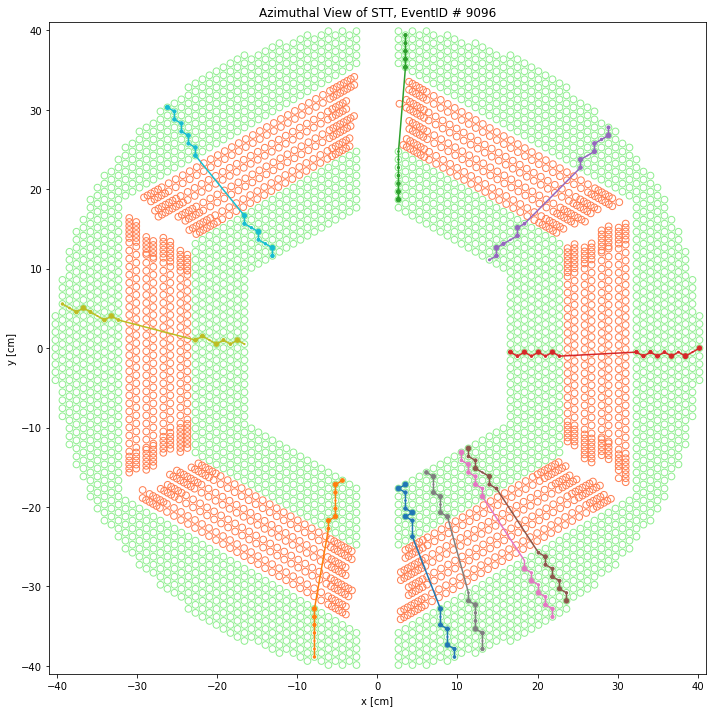

In [39]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_trkx.event_file[-10:])
p_ids = np.unique(true_trkx.pid)

for pid in p_ids:
    idx = true_trkx.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(pid))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()

## _(2.) - Plot Reco Event (Good)_

In [40]:
# lets plot reconstructed true event, i.e. event = 96
reco_trkx = torch.load(trkx_from_gnn[event_id], map_location=device)

In [41]:
reco_trkx.head()

,hit_id,track_id
0,26,0
1,151,1
2,76,2
3,51,3
4,102,4


Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

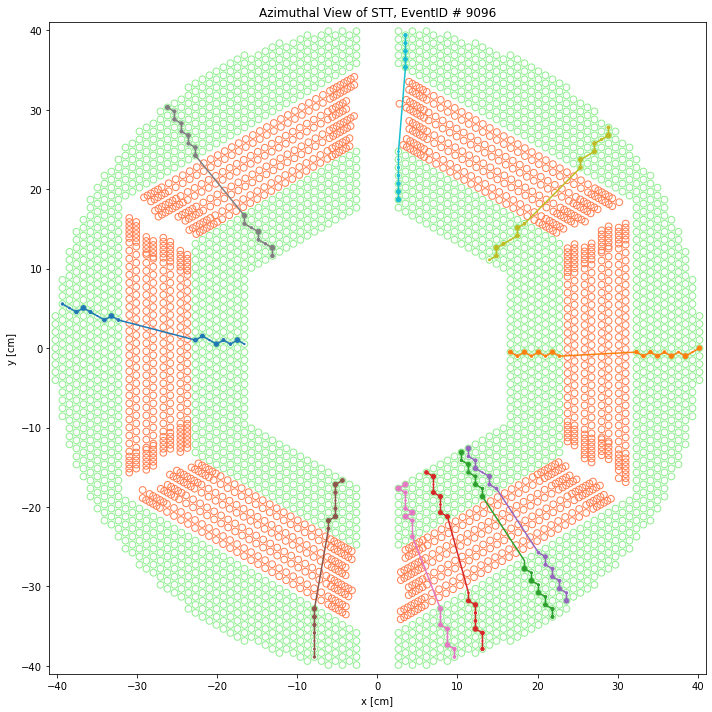

In [42]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_trkx.track_id)
for tid in t_ids:
    idx = reco_trkx.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
#ax.legend(fontsize=10, loc='best')
fig.tight_layout()

In [43]:
!./eval.sh $e_id

Out of 1000 events processing 1 events with 1 workers
Output directory: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 9096


In [44]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220529-224204
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   10
Reco. tracks matched:                   10
Reco. tracks matched to POI:                   10
Reco. tracks duplicated:                    0
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:               0.0000%
--------------------------------------------------
Run Time:      20220529-224910
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   10
Reco. tracks matched:                   10
Reco. tracks matched to POI:                   10
Reco. tracks duplicated:                    0
Tracking Eff.:      

## _(3.) - Plot True Event (Bad)_

In [45]:
# The Bad Event
event_id = 90

In [46]:
# true events
true_trkx = torch.load(proc_files[event_id], map_location=device)

In [47]:
true_trkx

Data(x=[151, 3], pid=[151], layers=[151], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_all/event0000009090', hid=[151], pt=[151], modulewise_true_edges=[2, 141], layerwise_true_edges=[2, 143], edge_index=[2, 707], y_pid=[707], scores=[1414])

In [48]:
np.unique(true_trkx.pid)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [49]:
# hit features
r, phi, ir = true_trkx.x.T

In [50]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [51]:
# compensate scaling
ir = ir.detach().numpy()*100

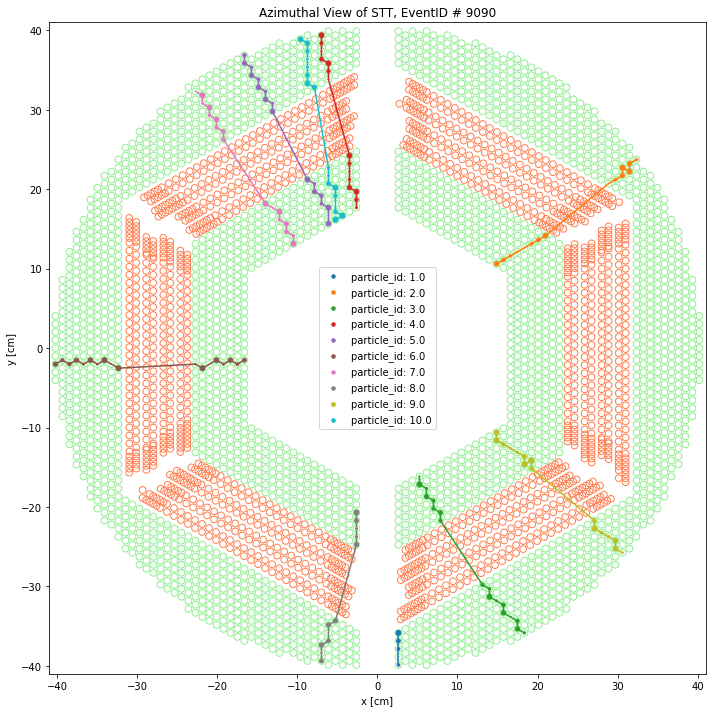

In [52]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_trkx.event_file[-10:])
p_ids = np.unique(true_trkx.pid)

for pid in p_ids:
    idx = true_trkx.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(pid))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()

## _(4.) - Plot Reco Event (Bad)_

In [53]:
# lets plot reconstructed true event, i.e. event = 96
reco_trkx = torch.load(trkx_from_gnn[event_id], map_location=device)

In [54]:
reco_trkx.head()

,hit_id,track_id
0,96,0
1,71,1
2,122,2
3,1,-1
4,171,3


In [55]:
np.unique(reco_trkx.track_id)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

Now, we've only the `hit_id` and `track_id`, what are corresponding spatial coordinates (x,y coordinates)? How about using `hit_id` to filter features from the true event?

Note, the `hit_id`, `track_id` in reco data are equiv. to `hid`, `pid` in true data.

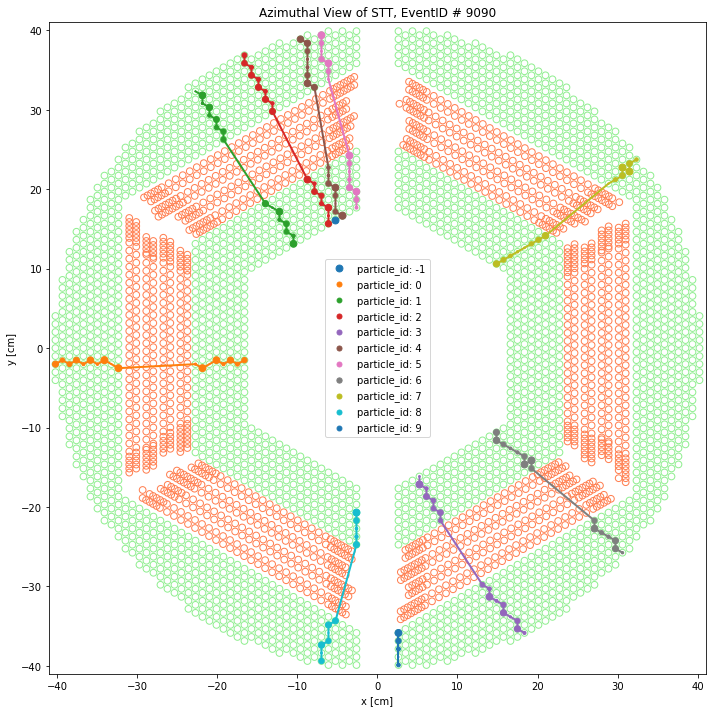

In [62]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_trkx.track_id)
for tid in t_ids:
    idx = reco_trkx.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()

In [57]:
!./eval.sh $e_id

Out of 1000 events processing 1 events with 1 workers
Output directory: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_reco_eval
Running 9090


In [58]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220529-224206
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   10
Reco. tracks matched:                   10
Reco. tracks matched to POI:                   10
Reco. tracks duplicated:                    0
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:               0.0000%
--------------------------------------------------
Run Time:      20220529-224912
Reconstructed tracks: /home/adeel/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   10
Reco. tracks matched:                   10
Reco. tracks matched to POI:                   10
Reco. tracks duplicated:                    0
Tracking Eff.:      

### (4.a) - Unassigned Hits

What is _`track_id=-1`_ contains?

The _hits_ not assigned to any track are collected under `track_id=-1`.

In [59]:
dup_hids = reco_trkx.query("track_id==-1")["hit_id"]

In [60]:
dup_hids.values

array([1], dtype=int32)

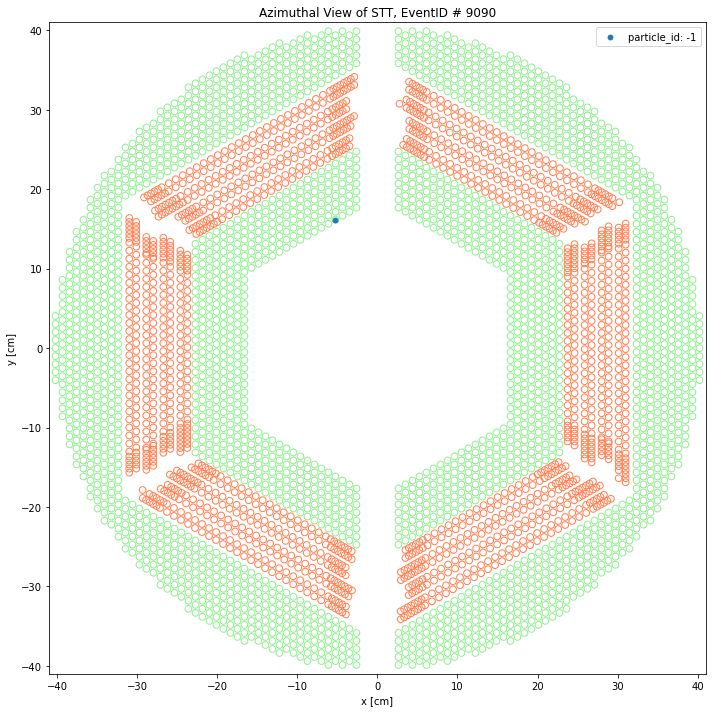

In [61]:
# lets plot the duplicated hits
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id

tid = -1
idx = reco_trkx.track_id == tid
ax.plot(x[idx], y[idx], '-', linewidth=0.5)
ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()